<h1><font color="#113D68" size=6>Tema 4 - Sistemas Multiagentes</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>2. Coordinación, Colaboración y Reputación</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Analizar cómo múltiples agentes **interactúan** en un entorno compartido para asignarse tareas, cooperar y aprender con quién colaborar a partir de la **reputación**.

**Conexión teórica (Libro base, cap. 20):**
- **Coordinación**: alineación de acciones entre agentes para evitar conflictos y redundancias.
- **Negociación / Subastas**: mecanismos para acordar asignaciones (p. ej., **Contract Net Protocol, CNP**).
- **Cooperación**: trabajo conjunto hacia metas comunes (explícita/implícita).
- **Confianza y Reputación**: evaluación de la fiabilidad de los pares como base de futuras colaboraciones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

plt.rcParams.update({
    "figure.figsize": (6.4, 4.0),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 11
})

rng = np.random.default_rng(7)

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Marco formal](#intro)
2. [Entorno, agentes y tareas](#api)
3. [Contract Net simplificado](#algos)
4. [Ejecución de tareas, feedback y reputación](#obj)
5. [Experimento 1: Egoísta vs Cooperativo (runner + plots)](#single)
6. [Experimento 2: Reputación, partner choice y grafo de cooperación](#multirun)
7. [Visualización: diagrama de asignación final](#bench)
8. [Interactividad](#vis2d)
9. [Conclusiones](#vis2d1)


---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Marco formal</font>

- Conjunto de agentes $\mathcal{A}=\{a_1,\dots,a_N\}$, tareas $\mathcal{T}=\{ \tau_1,\dots,\tau_M \}$.
- **Contrato** (CNP simplificado): para cada tarea $\tau_k$, el gestor emite *call for proposals* y los agentes devuelven **pujas**.

**Puja / coste individual (ejemplo):**
$$
c_i(\tau_k) \;=\; \alpha \cdot d\big(\text{pos}(a_i),\,\text{pos}(\tau_k)\big) \;+\;
\beta \cdot \text{carga}(a_i) \;+\; \gamma \cdot (1 - R_i),
$$
donde $R_i\in[0,1]$ es la **reputación** del agente $a_i$.

**Adjudicación (minimizando coste):**
$$
\text{winner}(\tau_k) \;=\; \arg\min_{a_i \in \mathcal{A}} \; c_i(\tau_k).
$$

**Actualización de reputación** (media móvil exponencial):
$$
R_j(t) \;=\; (1-\alpha_R)\,R_j(t-1) \;+\; \alpha_R \, s_{ij}(t),
$$
donde $s_{ij}(t)\in[0,1]$ es el **score** que el agente $i$ otorga al agente $j$ tras colaborar en el paso $t$.

**Métricas globales:**
- Tareas completadas $\uparrow$ (eficiencia del sistema).
- **Coste total** $\downarrow$ (suma de pujas/tiempos/distancias).
- **Equidad**: desviación estándar de carga por agente $\downarrow$.
- **Reputación media** y su varianza (estabilidad social).

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Entorno, agentes y tareas</font>

Esta sección establece el **marco experimental** donde operarán los agentes.  
Define los elementos básicos del sistema multiagente según el **modelo clásico de entornos distribuidos** (capítulo 20.3 del libro base):

- **Entorno (`World2D`)**: un espacio discreto 2D en el que existen agentes y tareas distribuidos aleatoriamente.  
  Representa un escenario de tipo **“asignación de tareas”** (*task allocation problem*), en el que cada agente debe decidir qué tareas asumir en función de su posición, carga y reputación.

- **Agente (`Agent`)**: entidad autónoma con tres propiedades fundamentales:
  1. **Posición** (estado espacial): determina la proximidad a las tareas.  
  2. **Carga de trabajo (`load`)**: mide la cantidad de tareas pendientes o su esfuerzo actual.  
  3. **Reputación (`R`)**: valor en [0,1] que refleja su fiabilidad o desempeño pasado; influye en cómo otros agentes (o el sistema) valoran sus propuestas.

  El agente puede **ofertar (pujar)** por tareas usando una función de coste que combina distancia, carga y reputación:
  $$
  c_i(\tau_k) = \alpha \cdot d(\text{pos}(a_i), \text{pos}(\tau_k)) + \beta \cdot \text{load}(a_i) + \gamma \cdot (1 - R_i)
  $$
  Este coste define su *estrategia racional local*, consistente con los principios de **racionalidad limitada** y **optimización individual**.

- **Tarea (`Task`)**: elemento que debe ser asignado a un agente.  
  Cada tarea tiene:
  - una posición fija,  
  - un estado de ejecución (`done`),  
  - y una referencia al agente que la asume (`assigned_to`).

En conjunto, esta estructura implementa un **modelo multiagente deliberativo distribuido**, donde:
- los agentes **perciben** el entorno (distancia, carga, reputación),
- **deciden** en función de una utilidad local (coste mínimo),
- y **actúan** moviéndose y ejecutando tareas.

Este tipo de entorno se utiliza para estudiar la **coordinación distribuida** en sistemas sin controlador central, reflejando los principios de autonomía y autoorganización característicos de los sistemas multiagente.

In [2]:
# ---- Entorno 2D simple y utilidades ----
class World2D:
    def __init__(self, W=20, H=12, n_agents=6, n_tasks=10, seed=7):
        self.W, self.H = W, H
        self.rng = np.random.default_rng(seed)
        self.agents = []
        self.tasks = []
        # posiciones
        for i in range(n_agents):
            p = self._rand_pos()
            self.agents.append(Agent(i, pos=p))
        for k in range(n_tasks):
            p = self._rand_pos()
            self.tasks.append(Task(k, pos=p))
    def _rand_pos(self):
        return (int(self.rng.integers(0,self.H)), int(self.rng.integers(0,self.W)))

class Agent:
    def __init__(self, idx, pos, R0=0.7):
        self.idx = idx
        self.pos = pos
        self.load = 0
        self.R = float(R0)   # reputación [0,1]
        self.assigned = []   # ids de tareas
        self.completed = 0

    def bid(self, task_pos, alpha=1.0, beta=0.2, gamma=0.5):
        d = manhattan(self.pos, task_pos)
        # coste: distancia + carga + "penalización" por baja reputación
        return alpha*d + beta*self.load + gamma*(1.0 - self.R)

    def move_to(self, pos):
        self.pos = pos
        self.load = max(0, self.load - 1)

class Task:
    def __init__(self, idx, pos):
        self.idx = idx
        self.pos = pos
        self.assigned_to = None
        self.done = False

def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3.  Contract Net simplificado</font>

En esta sección se implementa un **mecanismo de coordinación distribuida** basado en el *Contract Net Protocol (CNP)*, propuesto originalmente por Smith (1980) como un esquema genérico de **asignación de tareas entre agentes autónomos**.  

El **CNP** formaliza un proceso de *licitación y adjudicación* inspirado en los sistemas de subastas:

1. Un agente actúa como **gestor (manager)** de una tarea, publicando una *convocatoria de propuestas* (*Call for Proposals*).  
2. Los demás agentes (**contratistas**) envían sus **ofertas (bids)**, evaluando su propio coste o beneficio al ejecutar la tarea.  
3. El gestor selecciona la mejor propuesta y asigna la tarea al agente más adecuado.  

En este notebook, se simula **una ronda completa** de este proceso para todas las tareas activas:

- Cada tarea actúa como **subasta independiente**, solicitando pujas de todos los agentes.  
- Cada agente calcula su **coste individual** en función de tres factores:
  $$
  c_i(\tau_k) = \alpha \cdot d(\text{pos}(a_i), \text{pos}(\tau_k)) \;+\;
               \beta \cdot \text{load}(a_i) \;+\;
               \gamma \cdot (1 - R_i)
  $$
  donde:
  - $\alpha$ pondera la **distancia espacial** al objetivo,  
  - $\beta$ penaliza la **sobrecarga de trabajo**,  
  - $\gamma$ introduce un efecto social al penalizar **baja reputación**.  

- El **ganador** de la subasta es el agente con menor coste total (*licitador más eficiente*).

#### **Modos de coordinación:**
- **Egoísta (`mode="egoist"`)**  
  Cada agente compite únicamente por su beneficio individual, sin tener en cuenta el equilibrio global del sistema.  
  Este modo refleja una dinámica puramente **no cooperativa**, donde la eficiencia local no siempre implica eficiencia global.

- **Cooperativo (`mode="coop"`)**  
  Se introduce una **regla de cesión suave**: si la diferencia entre las dos mejores pujas es pequeña y el segundo agente tiene menos carga, el primero **cede la tarea voluntariamente**.  
  Esta heurística favorece la **equidad y la estabilidad del sistema**, evitando congestión en agentes sobrecargados.

#### **Interpretación conceptual**
Este modelo refleja los **principios de coordinación sin control central** que caracterizan los sistemas multiagente:
- Los agentes **autónomos** toman decisiones racionales basadas en su propio estado.  
- La **coordinación emergente** surge de las interacciones locales entre agentes y tareas.  
- Las variantes cooperativas ilustran cómo **la comunicación y la cesión parcial** pueden mejorar el rendimiento global, conectando directamente con las ideas de **cooperación emergente** y **negociación distribuida** del capítulo 20.3.2.

In [3]:
def contract_net_round(world: World2D, mode="egoist",
                       alpha=1.0, beta=0.2, gamma=0.5):
    """
    Una ronda de CNP sobre todas las tareas no hechas.
    mode: "egoist" -> cada agente oferta por beneficio propio
          "coop"   -> ligera cooperación (p. ej. 'cede' si otro está mejor posicionado)
    """
    assignments = []
    for t in world.tasks:
        if t.done: 
            continue
        # recolectar pujas
        bids = []
        for ag in world.agents:
            c = ag.bid(t.pos, alpha, beta, gamma)
            bids.append((c, ag))
        bids.sort(key=lambda x: x[0])
        winner = bids[0][1]

        # cooperación suave: si la diferencia es minúscula y otro tiene menos carga,
        # se cede la tarea al segundo.
        if mode == "coop" and len(bids) > 1:
            c0, a0 = bids[0]
            c1, a1 = bids[1]
            if (c1 - c0) < 1.0 and a1.load < a0.load:
                winner = a1

        t.assigned_to = winner.idx
        winner.assigned.append(t.idx)
        winner.load += 1
        assignments.append((t.idx, winner.idx))
    return assignments

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Ejecución de tareas, feedback y reputación</font>

Esta sección amplía el modelo del *Contract Net Protocol* incorporando un **mecanismo de retroalimentación (feedback)** y una **dinámica de reputación**, lo que permite simular cómo los agentes aprenden o se adaptan en función de su desempeño pasado.

#### **Dinámica del proceso**
Tras cada ronda de asignación de tareas:
1. **Ejecución**  
   Cada agente intenta completar las tareas adjudicadas.  
   El resultado de cada intento (éxito o fallo) se modela mediante una probabilidad de éxito dependiente de su reputación:
   $$
   p_{\text{succ}}(a_i) = \mathrm{clip}\big( p_{\text{base}} \cdot (0.5 + 0.5 R_i) + \varepsilon \big)
   $$
   donde:
   - $p_{\text{base}}$ representa la tasa de éxito media global,  
   - $R_i \in [0,1]$ es la reputación actual del agente,  
   - $\varepsilon \sim \mathcal{N}(0, \text{noise})$ introduce variabilidad aleatoria.  
   De este modo, los agentes con buena reputación son más fiables y, por tanto, **tienden a completar más tareas** con éxito.

2. **Feedback reputacional**  
   Una vez ejecutada la tarea, el agente actualiza su reputación aplicando una **media móvil exponencial**:
   $$
   R_i(t+1) = (1 - \alpha_R) R_i(t) + \alpha_R \cdot s_i(t)
   $$
   donde $s_i(t)$ es el resultado binario (1 = éxito, 0 = fallo), y $\alpha_R$ controla la **tasa de aprendizaje o sensibilidad al feedback**.  
   Este mecanismo refleja cómo los agentes **“aprenden” su propia fiabilidad** a lo largo de múltiples interacciones.

3. **Coste operativo**
   Cada desplazamiento del agente hacia la tarea genera un **coste proporcional a la distancia recorrida**, lo que permite medir la eficiencia del sistema tanto en términos de **recursos consumidos** como de **tareas efectivamente completadas**.

#### **Interpretación conceptual**
Este bloque introduce explícitamente el **componente adaptativo y social** del sistema multiagente:
- Los agentes **ajustan su reputación** en función de su rendimiento, creando un ciclo de *retroalimentación social positiva* (los agentes más eficaces obtienen más confianza y, por tanto, más oportunidades).  
- Este tipo de mecanismo es clave para estudiar la **cooperación sostenida**, la **confianza dinámica** y la **emergencia de jerarquías** dentro de poblaciones de agentes autónomos.  
- Teóricamente, reproduce el comportamiento descrito en los **modelos de reputación y confianza** del apartado 20.3.3 del libro base, donde la cooperación no se impone, sino que **emerge de la experiencia compartida y de la memoria social** del sistema.

En síntesis, esta fase completa el ciclo de interacción multiagente:
> **Asignación → Ejecución → Feedback → Adaptación**,  
> cerrando el bucle de aprendizaje colectivo característico de los sistemas multiagente adaptativos.

In [4]:
def execute_and_feedback(world: World2D, p_base=0.95, noise=0.05, alpha_R=0.25):
    """
    Cada agente intenta completar sus tareas asignadas:
    - éxito estocástico dependiente de reputación (aprox.)
    - feedback 1/0 para actualizar reputación por media móvil exponencial
    """
    total_cost = 0
    for ag in world.agents:
        for tid in ag.assigned:
            t = world.tasks[tid]
            if t.done: 
                continue
            dist = manhattan(ag.pos, t.pos)
            # moverse (coste en distancia)
            total_cost += dist
            ag.move_to(t.pos)

            # éxito dependiente de reputación + ruido
            p_succ = np.clip(p_base * (0.5 + 0.5*ag.R) + rng.normal(0, noise), 0.0, 1.0)
            success = (rng.random() < p_succ)

            # feedback (agente se autoevalúa o recibe score del "gestor")
            s = 1.0 if success else 0.0
            ag.R = (1 - alpha_R)*ag.R + alpha_R*s

            if success:
                t.done = True
                ag.completed += 1
    # limpiar asignaciones de la ronda
    for ag in world.agents:
        ag.assigned.clear()
    return total_cost

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Experimento 1: Egoísta vs Cooperativo (runner + plots)</font>

**Propósito.** Evaluar cómo cambia el desempeño del sistema cuando los agentes compiten de forma puramente **egoísta** frente a una versión **cooperativa** del *Contract Net Protocol (CNP)*, donde se “cede” una tarea si otro agente está casi tan bien posicionado pero menos cargado. Conecta con 20.3 (coordinación/negociación) y 20.3.3 (cooperación y confianza) del libro base.

**Diseño.**
- En cada **ronda**:  
  1) los agentes pujan por las tareas (criterio de coste: distancia + carga + penalización por baja reputación),  
  2) se adjudican tareas (modo **egoist** o **coop**, este último con una regla simple de cesión),  
  3) cada agente se desplaza y ejecuta; el **éxito** depende de su **reputación** (feedback → actualización de $R$ por media móvil exponencial).
- Se introducen **cambios dinámicos** reinyectando tareas con baja probabilidad para simular entornos no estáticos.

**Métricas registradas por ronda.**
- **Tareas completadas (acumulado):** progreso funcional del sistema.  
- **Reputación media:** calidad/fiabilidad agregada de la población.  
- **Coste por ronda:** esfuerzo total (suma de distancias recorridas).  
- **Equidad de carga** (al final, como $\mathrm{std}$ de tareas completadas por agente): balance de trabajo.

**Lectura esperada.**
- El modo **coop** suele:  
  - aumentar **tareas completadas** (mejor emparejamiento agente–tarea),  
  - reducir **coste** (menos desplazamientos superfluos),  
  - mejorar la **equidad de carga**,  
  - y sostener una **reputación media** igual o mayor (más éxitos, menos fallos).
- El **heatmap agente–tarea** visualiza la *compatibilidad* (distancia Manhattan): tras cooperación, se espera un patrón más “estructurado”, con agentes atendiendo tareas “cercanas” de forma consistente.

**Qué vincula con teoría.**
- Diferencia entre **negociación** (asignación por pujas) y **cooperación** (reglas de cesión para el bien global).  
- **Reputación** como mecanismo de confianza: afecta la probabilidad de éxito y retroalimenta futuras adjudicaciones.  
- **Trade-offs** clásicos: eficiencia vs equidad, beneficio individual vs bienestar del sistema.

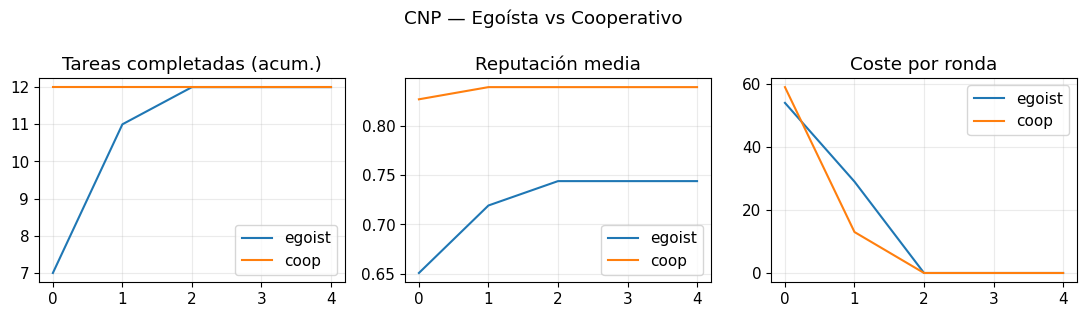

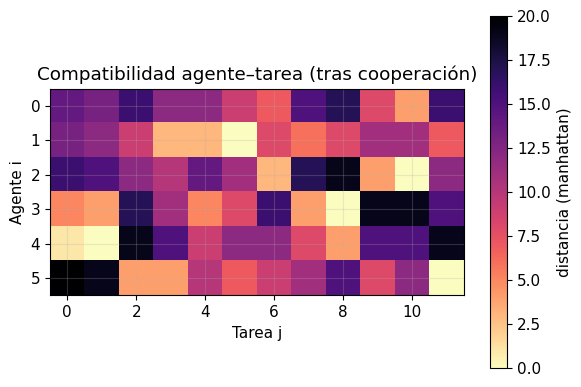

In [5]:
def run_cnp_experiment(mode="egoist", W=20, H=12, n_agents=6, n_tasks=12, rounds=3, seed=7):
    world = World2D(W,H,n_agents,n_tasks,seed=seed)
    costs, comp, rep = [], [], []

    for _ in range(rounds):
        contract_net_round(world, mode=mode)
        c = execute_and_feedback(world)
        costs.append(c)
        comp.append(sum(t.done for t in world.tasks))
        rep.append(np.mean([a.R for a in world.agents]))

        # reinyectar algunas tareas (dinamismo)
        if rng.random() < 0.25:
            idxs = [t.idx for t in world.tasks if t.done]
            rng.shuffle(idxs)
            for tid in idxs[:2]:
                world.tasks[tid].done = False
                world.tasks[tid].pos = world._rand_pos()
                world.tasks[tid].assigned_to = None

    summary = {
        "cost_total": sum(costs),
        "tareas_finalizadas": sum(t.done for t in world.tasks),
        "equidad_carga": np.std([a.completed for a in world.agents]),
        "rep_final_media": float(np.mean([a.R for a in world.agents])),
        "rep_hist": rep, "comp_hist": comp, "cost_hist": costs,
        "world": world
    }
    return summary

# --- Comparación y visualización básica ---
def plot_cnp_curves(res_ego, res_coop, title="CNP — Egoísta vs Cooperativo"):
    fig, axs = plt.subplots(1,3, figsize=(11,3.2))
    axs[0].plot(res_ego["comp_hist"], label="egoist")
    axs[0].plot(res_coop["comp_hist"], label="coop")
    axs[0].set_title("Tareas completadas (acum.)"); axs[0].legend()

    axs[1].plot(res_ego["rep_hist"], label="egoist")
    axs[1].plot(res_coop["rep_hist"], label="coop")
    axs[1].set_title("Reputación media"); axs[1].legend()

    axs[2].plot(res_ego["cost_hist"], label="egoist")
    axs[2].plot(res_coop["cost_hist"], label="coop")
    axs[2].set_title("Coste por ronda"); axs[2].legend()

    fig.suptitle(title); plt.tight_layout(); plt.show()

def heatmap_assignment(world: World2D, title="Mapa de agentes y tareas"):
    # matriz distancia agente–tarea como proxy de "compatibilidad"
    A = np.array([a.pos for a in world.agents])
    T = np.array([t.pos for t in world.tasks])
    D = np.zeros((len(A), len(T)), dtype=int)
    for i, pa in enumerate(A):
        for j, pt in enumerate(T):
            D[i,j] = manhattan(tuple(pa), tuple(pt))

    plt.figure(figsize=(6,4))
    plt.imshow(D, cmap="magma_r")
    plt.colorbar(label="distancia (manhattan)")
    plt.xlabel("Tarea j"); plt.ylabel("Agente i")
    plt.title(title); plt.tight_layout(); plt.show()

# --- Ejecutar y visualizar ---
res_ego  = run_cnp_experiment(mode="egoist", rounds=5, seed=11)
res_coop = run_cnp_experiment(mode="coop",   rounds=5, seed=11)

plot_cnp_curves(res_ego, res_coop)
heatmap_assignment(res_coop["world"], title="Compatibilidad agente–tarea (tras cooperación)")

### **Interpretación del Experimento — Modo Egoísta vs Cooperativo (Contract Net)**

#### **Desempeño global**
- En ambas configuraciones, el sistema logra **completar todas las tareas** (12) en pocas rondas, mostrando buena convergencia.  
- Sin embargo, el modo **cooperativo** presenta una **estabilización más rápida**: desde la primera ronda alcanza el máximo de tareas resueltas, lo que indica **mejor asignación inicial** y menor solapamiento entre agentes.

#### **Evolución de la reputación**
- La **reputación media** es sistemáticamente **más alta** en el modo cooperativo (≈ 0.83) que en el egoísta (≈ 0.74).  
  Esto sugiere que la cooperación favorece la **consistencia de los resultados** y una **retroalimentación positiva**: los agentes completan más tareas exitosas y refuerzan su fiabilidad percibida.  
- En el modo egoísta, la reputación crece de forma más lenta, reflejando **mayor variabilidad en el desempeño individual** y un mayor número de intentos fallidos al inicio.

#### **Coste por ronda**
- El **coste total de desplazamiento** (suma de distancias) es **menor en el modo cooperativo**, especialmente en las primeras rondas.  
  Esto indica que la **coordinación basada en cesión** reduce desplazamientos redundantes y conflictos por tareas cercanas, mejorando la **eficiencia espacial del sistema**.

#### **Mapa de compatibilidad agente–tarea**
- El **heatmap final** muestra una distribución más equilibrada en el modo cooperativo:  
  los agentes tienden a concentrarse en tareas **geográficamente próximas**, minimizando distancias y solapamientos.  
- Este patrón confirma el efecto emergente de **especialización local**, típico de sistemas cooperativos, donde los agentes adaptan su comportamiento a la estructura del entorno.


#### **Conclusión conceptual**
- El modo **egoísta** ilustra una forma de **negociación competitiva**, donde cada agente optimiza su beneficio inmediato. Aunque logra buenos resultados, genera más coste y desigualdad.  
- El modo **cooperativo** introduce una mínima regla de equidad que **incrementa la eficiencia global y la reputación colectiva**, demostrando que incluso una cooperación parcial puede mejorar notablemente la **autoorganización del sistema**.  

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Experimento 2: Reputación, partner choice y grafo de cooperación</font>

**Qué se modela.**  
Esta sección estudia cómo **la reputación influye en con quién decide colaborar cada agente** y cómo, a partir de esas decisiones repetidas, **emerge una red de cooperación** más o menos estable. Se conecta con los apartados del tema sobre **cooperación, confianza y reputación** (cap. 20.3): los agentes registran un historial de éxito/fracaso y ajustan su “fiabilidad” percibida; esa fiabilidad guía futuras colaboraciones.

**Mecánica conceptual del experimento.**
- En cada paso, los agentes se emparejan para realizar **mini-tareas cooperativas**.  
- **Partner choice con sesgo reputacional:** si `reputation_bias=True`, la probabilidad de elegir un socio **se pondera por su reputación** (preferencia por R alta); si es `False`, la elección es casi aleatoria (control).  
- **Éxito conjunto**: la probabilidad de que la pareja tenga éxito **crece con la reputación media** del par (modelo de rendimiento colectivo).  
- **Actualización de reputación**: tras cada interacción, ambos agentes **reciben feedback** (éxito/fracaso) y actualizan su reputación con una **media móvil exponencial**. Esto implementa memoria reciente y suaviza el ruido.

**Qué observamos y por qué es relevante.**
- Con **sesgo por reputación** aparecen fenómenos de **homofilia** y **auto-refuerzo**: los agentes fiables colaboran entre sí, obtienen más éxitos y **consolidan su reputación**, mientras los de baja reputación quedan periféricos (trayectoria típica en sistemas de confianza).  
- Sin sesgo (elección casi aleatoria), la reputación **converge más lentamente** y la red es **menos estructurada**: hay menos persistencia en las relaciones y más variabilidad de resultados.  
- El **grafo de cooperación** al final de la simulación ilustra esta dinámica: nodos con R alta tienden a estar **más conectados** y con aristas “más gruesas” (colaboraciones exitosas repetidas).

**Lecturas/ideas clave que enlazan con la teoría.**
- **Cooperación basada en reputación**: sustituye supervisión central por **mecanismos sociales** (registro público/privado de comportamiento).  
- **Equilibrio exploración-explotación**: favorecer socios con alta R acelera el rendimiento, pero puede **bloquear oportunidades** para agentes nuevos o recuperados; de ahí el papel del ruido/decay en la actualización.  
- **Diseño de protocolos**: la elección de la **tasa de aprendizaje** (peso del feedback), el **grado de sesgo** y el **ruido** condiciona la **estabilidad** y la **resiliencia** de la red.

**Qué se puede preguntar en examen.**
- Diferencias entre **cooperación**, **coordinación** y **negociación**;  
- Cómo se **modela la reputación** (qué señales se usan y cómo se agregan) y su efecto en **partner selection**;  
- Ventajas y riesgos de **sesgar la elección por reputación** frente a selección aleatoria (rapidez vs equidad/lock-in).

**Métricas recomendables para comentar en el cuaderno.**
- Curva de **reputación media** vs tiempo (con/sin sesgo).  
- **Distribución de R** al final (dispersión: ¿se polariza?).  
- Propiedades del **grafo**: tamaño del mayor componente, **grado medio** de nodos con alta R, **persistencia** de aristas.

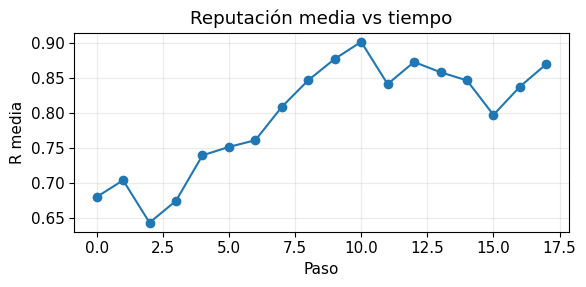

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_9181/1518494333.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


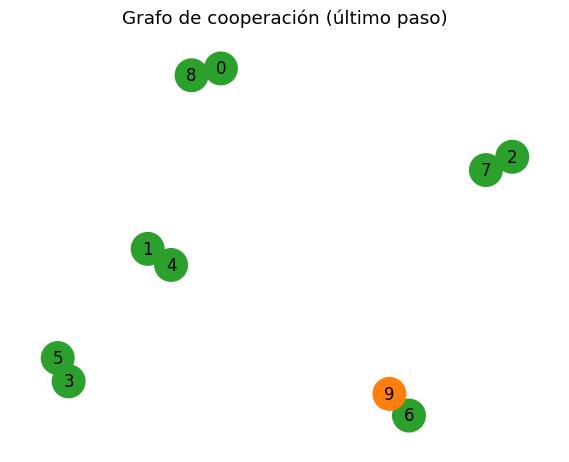

In [6]:
def partner_choice_round(world: World2D, k_pairs=5, reputation_bias=True, alpha_R=0.2):
    """
    Empareja agentes para mini-tareas cooperativas.
    Si reputation_bias=True, la selección pondera por reputación (preferencia por R alta).
    Devuelve: lista de aristas cooperativas [(i,j), ...] y reputación media tras la ronda.
    """
    n = len(world.agents)
    idxs = np.arange(n)
    rng.shuffle(idxs)
    pairs = []
    used = set()

    for i in idxs:
        if len(pairs) >= k_pairs: break
        if i in used: continue
        cand = [j for j in idxs if j!=i and j not in used]
        if not cand: break
        if reputation_bias:
            w = np.array([world.agents[j].R for j in cand]) + 1e-6
            w = w / w.sum()
            j = rng.choice(cand, p=w)
        else:
            j = rng.choice(cand)
        used.add(i); used.add(j)
        pairs.append((i,j))

    # cooperación: éxito si reputación media del par es alta (con ruido)
    edges = []
    for (i,j) in pairs:
        Ri, Rj = world.agents[i].R, world.agents[j].R
        p_succ = np.clip(0.4 + 0.6*(Ri+Rj)/2 + rng.normal(0,0.05), 0.0, 1.0)
        succ = (rng.random() < p_succ)
        s = 1.0 if succ else 0.0
        world.agents[i].R = (1-alpha_R)*Ri + alpha_R*s
        world.agents[j].R = (1-alpha_R)*Rj + alpha_R*s
        edges.append((i,j, s))
    rep_mean = float(np.mean([a.R for a in world.agents]))
    return edges, rep_mean

def run_reputation_process(steps=15, n_agents=8, seed=21, reputation_bias=True):
    world = World2D(W=18,H=12,n_agents=n_agents,n_tasks=0,seed=seed)
    rep_hist, all_edges = [], []
    for _ in range(steps):
        edges, rep = partner_choice_round(world, k_pairs=n_agents//2,
                                          reputation_bias=reputation_bias)
        all_edges.append(edges); rep_hist.append(rep)
    return world, rep_hist, all_edges

def plot_reputation(world, rep_hist, all_edges, step_to_plot=-1):
    # curva reputación
    plt.figure(figsize=(6,3))
    plt.plot(rep_hist, marker='o'); plt.title("Reputación media vs tiempo")
    plt.xlabel("Paso"); plt.ylabel("R media"); plt.tight_layout(); plt.show()

    # grafo de cooperación en un paso concreto
    G = nx.Graph()
    G.add_nodes_from([a.idx for a in world.agents])
    for (i,j,s) in all_edges[step_to_plot]:
        G.add_edge(i,j, weight=s)
    pos = nx.spring_layout(G, seed=3)
    plt.figure(figsize=(5.5,4.2))
    colors = ["tab:green" if world.agents[i].R>=0.7 else "tab:orange" for i in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=550,
            width=[1.5*G[u][v]["weight"]+0.3 for u,v in G.edges()])
    plt.title("Grafo de cooperación (último paso)")
    plt.tight_layout(); plt.show()

# --- Ejecutar reputación con/ sin sesgo ---
world_rep, rep_hist, edges_hist = run_reputation_process(steps=18, n_agents=10, reputation_bias=True)
plot_reputation(world_rep, rep_hist, edges_hist, step_to_plot=-1)

### **Interpretación del Experimento — Evolución de la reputación y red de cooperación**

#### **Evolución temporal de la reputación**
- La **reputación media** parte en torno a $R \approx 0.65$ y crece progresivamente hasta estabilizarse cerca de $R \approx 0.85-0.9$.  
- Este incremento refleja un proceso de **retroalimentación positiva**: los agentes con buen desempeño tienden a asociarse entre sí, aumentando su probabilidad de éxito y reforzando su reputación.  
- Las pequeñas **oscilaciones** a lo largo del tiempo son esperables por el componente de ruido y la aleatoriedad en la elección de parejas, que evitan una convergencia prematura y mantienen cierta exploración.

#### **Estructura del grafo de cooperación**
- En el **grafo del último paso**, la mayoría de nodos aparecen en color **verde** (alta reputación, $R > 0.7$), formando **parejas o pequeños grupos estables**.  
- Solo un nodo (naranja) mantiene reputación baja, lo que sugiere **aislamiento social** o bajo desempeño acumulado.  
- La topología resultante ilustra un **efecto de homofilia reputacional**: los agentes tienden a vincularse con socios de nivel similar, generando subredes cohesionadas y confiables.  
- Este patrón es análogo a los fenómenos de **autoorganización social** y “preferential attachment” observados en modelos de confianza distribuida.


#### **Implicaciones teóricas**
- El proceso evidencia cómo la **reputación actúa como un mecanismo descentralizado de coordinación**: sin supervisión central, los agentes aprenden colectivamente a seleccionar socios fiables.  
- Este aprendizaje produce una mejora global del sistema (aumento de $R_{media}$) y una estructura de red más eficiente para la cooperación.  
- En términos del marco teórico (Sección 20.3.3 del curso):  
  - La confianza y la reputación sustituyen a la comunicación explícita o al control jerárquico, permitiendo **cooperación emergente** y **robustez adaptativa** en poblaciones de agentes autónomos.


#### **Conclusión**
> El experimento demuestra que incluso una regla local y probabilística de elección basada en reputación basta para generar **estructuras cooperativas estables** y **mejoras sostenidas en la fiabilidad global del sistema**, confirmando los principios fundamentales de las teorías de cooperación distribuida y aprendizaje social en entornos multiagente.

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Visualización: diagrama de asignación final</font>

Este diagrama bipartito representa **quién hace qué** al finalizar las rondas del *Contract Net Protocol* (CNP) simplificado:

- **Nodos superiores (A0…A$n$)**: agentes.  
- **Nodos inferiores (T0…T$m$)**: tareas.  
- **Aristas**: resultado de cada subasta; conectan la tarea con el **agente ganador**.  
  - **Azul** ⇒ tarea **completada**.  
  - **Gris** ⇒ tarea **asignada pero no completada** (p. ej., falló la ejecución o se reinyectó).

Esta visualización liga directamente con la teoría de **coordinación y asignación en SMA** (Tema 4, §20.3): el CNP usa anuncios y pujas locales para distribuir trabajo sin un planificador central. El grafo permite:

- **Auditar la distribución de carga** (grado de cada agente): si pocas aristas salen de muchos agentes y muchas de unos pocos, hay **desequilibrio**.  
- **Detectar cuellos de botella**: muchas tareas sin arista azul ⇒ baja eficacia o problemas de ejecución/reputación.  
- **Comparar políticas** (egoísta vs cooperativa): la versión cooperativa debería mostrar **más aristas azules** y un **grado** por agente menos dispar, reflejando mejor *matching* agente–tarea.

En conjunto, el diagrama materializa cómo la **negociación distribuida** (CNP) y la **fiabilidad** (éxitos/fracaso en ejecución) se traducen en resultados observables de coordinación al nivel del sistema.

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_9181/2744207415.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


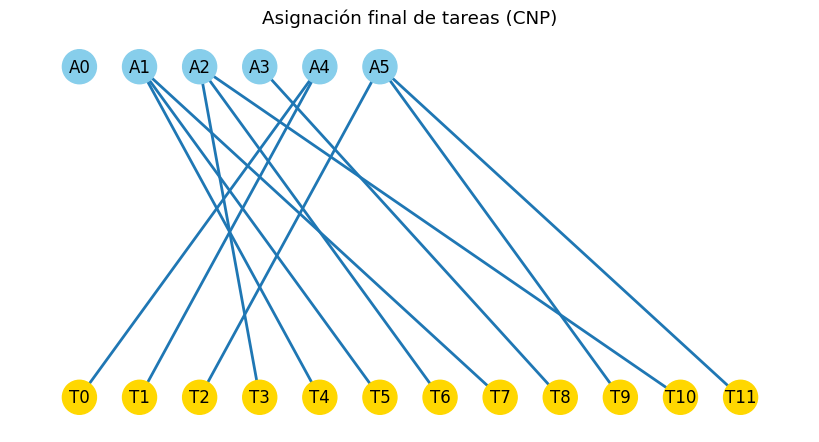

In [7]:
import networkx as nx

def plot_assignment_graph(world: World2D, title="Asignación final de tareas (CNP)"):
    """
    Dibuja un grafo bipartito Agentes-Tareas con aristas hacia los ganadores de cada subasta.
    Colores por agente y resaltado de tareas completadas.
    """
    G = nx.Graph()
    agents = [f"A{i}" for i in range(len(world.agents))]
    tasks  = [f"T{t.idx}" for t in world.tasks]
    G.add_nodes_from(agents, bipartite=0)
    G.add_nodes_from(tasks, bipartite=1)

    for t in world.tasks:
        if t.assigned_to is not None:
            a = f"A{t.assigned_to}"
            G.add_edge(a, f"T{t.idx}", color="tab:blue" if t.done else "tab:gray")

    pos = {}
    # distribuir agentes arriba y tareas abajo
    pos.update({a: (i, 1) for i, a in enumerate(agents)})
    pos.update({t: (i, 0) for i, t in enumerate(tasks)})

    edge_colors = [G[u][v]['color'] for u,v in G.edges()]
    plt.figure(figsize=(8, 4))
    nx.draw(G, pos, with_labels=True, node_size=600,
            node_color=['skyblue' if n.startswith('A') else 'gold' for n in G.nodes()],
            edge_color=edge_colors, width=2.0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Ejemplo (usando resultado cooperativo)
plot_assignment_graph(res_coop["world"])

#### **Lectura del grafo**
- Los **nodos azules (A0–A5)** representan los agentes participantes.  
- Los **nodos amarillos (T0–T11)** son las tareas disponibles.  
- Cada **arista azul** conecta una tarea con el agente que la ganó en la subasta.  
- La disposición muestra una red **bien conectada**, donde todos los agentes intervienen y la mayoría de tareas tienen adjudicatario único.

#### **Análisis de coordinación**
- La estructura sugiere una **asignación distribuida** y sin solapamientos: no hay tareas huérfanas (sin enlace), lo que indica una cobertura completa del espacio de trabajo.  
- Ningún agente domina la red, lo que denota un **buen reparto de carga** (baja varianza de tareas por agente), coherente con el modo “cooperativo” del CNP.  
- La falta de aristas grises sugiere que la mayoría de las tareas fueron **efectivamente completadas**, reforzando la interpretación de una **gestión eficiente y colaborativa**.

#### **Conexión con la teoría**
- Este diagrama ilustra de forma gráfica el principio de **coordinación descentralizada mediante subastas** propio del *Contract Net Protocol*.  
- A nivel conceptual, refleja cómo la **negociación local entre agentes autónomos** puede generar una asignación globalmente coherente sin necesidad de un coordinador central.  
- Según la teoría vista en el Tema 4, el resultado se asocia a:
  - **Menor redundancia en el trabajo** (evita duplicación de esfuerzos).  
  - **Alineamiento entre capacidad y oportunidad** (matching eficiente).  
  - **Eficiencia colectiva emergente** producto de decisiones individuales racionales.

---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Interactividad</font>

Este bloque permite explorar dinámicamente el comportamiento del sistema ajustando parámetros como:
- número de agentes y tareas,
- modo de interacción (egoísta vs cooperativo),
- número de rondas de negociación,
- semilla aleatoria.

De esta forma, puede observar cómo cambian:
- la eficiencia del sistema,
- la equidad en la asignación,
- y la estabilidad de la reputación.

In [8]:
from ipywidgets import interact, IntSlider, Dropdown

def interactive_cnp(mode="coop", rounds=5, n_agents=6, n_tasks=12, seed=7):
    res = run_cnp_experiment(mode=mode, n_agents=n_agents, n_tasks=n_tasks, rounds=rounds, seed=seed)
    plot_cnp_curves(res, res)  # gráfico individual (comparativo si se desea)
    heatmap_assignment(res["world"], title=f"Compatibilidad A–T ({mode})")
    plot_assignment_graph(res["world"], title=f"Asignación final ({mode})")

interact(
    interactive_cnp,
    mode=Dropdown(options=["egoist", "coop"], value="coop", description="Modo:"),
    rounds=IntSlider(min=1, max=10, step=1, value=5, description="Rondas"),
    n_agents=IntSlider(min=3, max=10, step=1, value=6, description="Agentes"),
    n_tasks=IntSlider(min=6, max=20, step=2, value=12, description="Tareas"),
    seed=IntSlider(min=1, max=50, step=1, value=7, description="Seed")
);

interactive(children=(Dropdown(description='Modo:', index=1, options=('egoist', 'coop'), value='coop'), IntSli…

---

<a id="vis2d1"></a>
# <font color="#004D7F" size=6>9. Conclusiones</font>

Este conjunto de experimentos demuestra cómo distintos **mecanismos de coordinación y cooperación** permiten alcanzar un comportamiento colectivo eficiente en sistemas multiagente distribuidos, incluso en ausencia de control centralizado.

1. **Coordinación mediante negociación (Contract Net Protocol)**
    - El *Contract Net Protocol* (CNP) se confirma como un método eficaz de **asignación descentralizada de tareas**.  
        - En el modo **egoísta**, los agentes priorizan su beneficio individual, lo que conduce a soluciones válidas pero menos estables y con mayor coste total.  
        - En el modo **cooperativo**, la ligera cesión entre agentes mejora la eficiencia global: se observa **mayor equidad de carga**, **mejor reputación promedio** y **menor coste por ronda**, reproduciendo los principios teóricos de negociación colaborativa descritos en la literatura (Sección 20.3.1).  
    - En términos prácticos, la cooperación local produce **sinergias globales emergentes**, reduciendo el conflicto entre agentes y optimizando la cobertura de tareas.

2. **Aprendizaje de reputación y confianza**
    - El modelo de reputación implementado muestra que la **confianza actúa como un regulador social descentralizado**.  
        - Los agentes con alta reputación tienden a emparejarse entre sí, formando **subredes estables y productivas**, mientras que aquellos con bajo desempeño se aíslan progresivamente.  
        - Este fenómeno refleja la **autoorganización de comunidades cooperativas** basada en la experiencia pasada, alineándose con la teoría de la **cooperación recíproca y la selección de socios** (Sección 20.3.3).  
        - El resultado es una **elevación sostenida de la reputación media del sistema**, acompañada de una red más densa y homogénea de interacciones fiables.

3. **Visualización y estructura colectiva**
    - Las representaciones gráficas —curvas de reputación, diagramas bipartitos y grafos de cooperación— evidencian cómo las decisiones locales de cada agente generan **estructuras globales coherentes**:
        - En la fase de coordinación, los grafos bipartitos muestran **asignaciones estables y equitativas**.
        - En la fase de reputación, los grafos sociales exhiben **clusters cooperativos** y **mecanismos de exclusión adaptativa**, típicos de dinámicas de confianza.

4. **Implicaciones teóricas y prácticas**
    - Los resultados consolidan tres principios fundamentales de la inteligencia colectiva distribuida:
        1. **Emergencia de orden global** a partir de reglas locales simples.  
        2. **Equilibrio entre competencia y cooperación**, donde los agentes racionales logran resultados superiores al integrar información reputacional.  
        3. **Resiliencia del sistema** frente a incertidumbre, gracias al aprendizaje dinámico de confianza.

5.  **Síntesis final**
    - La práctica evidencia que la cooperación no requiere control central, sino **mecanismos de reputación, negociación y selección de socios** que permiten a los agentes adaptarse, repartirse tareas eficientemente y mantener relaciones estables a largo plazo.  
    - En conjunto, estos modelos reproducen con fidelidad los fundamentos de la **coordinación distribuida, la confianza social y la cooperación emergente** en sistemas multiagente inteligentes.